In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.stats import ttest_ind, linregress
import math
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
geq = pd.read_csv("../GEQ/GEQ_scores.csv", dtype={"Player Number": np.int64}, decimal=",").set_index("Player Number")
ftq = pd.read_csv("../FTQ/FTQ_scores.csv", dtype={"Player Number": np.int64}).set_index("Player Number")
hr = pd.read_csv("../Processed/hr_summary.csv", dtype={"player": np.int64}, decimal=".").set_index("player")
gameplay = pd.read_csv("../Processed/player_stats.csv", dtype={"player": np.int64}, decimal=".").set_index("player")

In [3]:
full_set = geq.join(ftq).join(hr).join(gameplay)

## Correlation matrix

<Axes: >

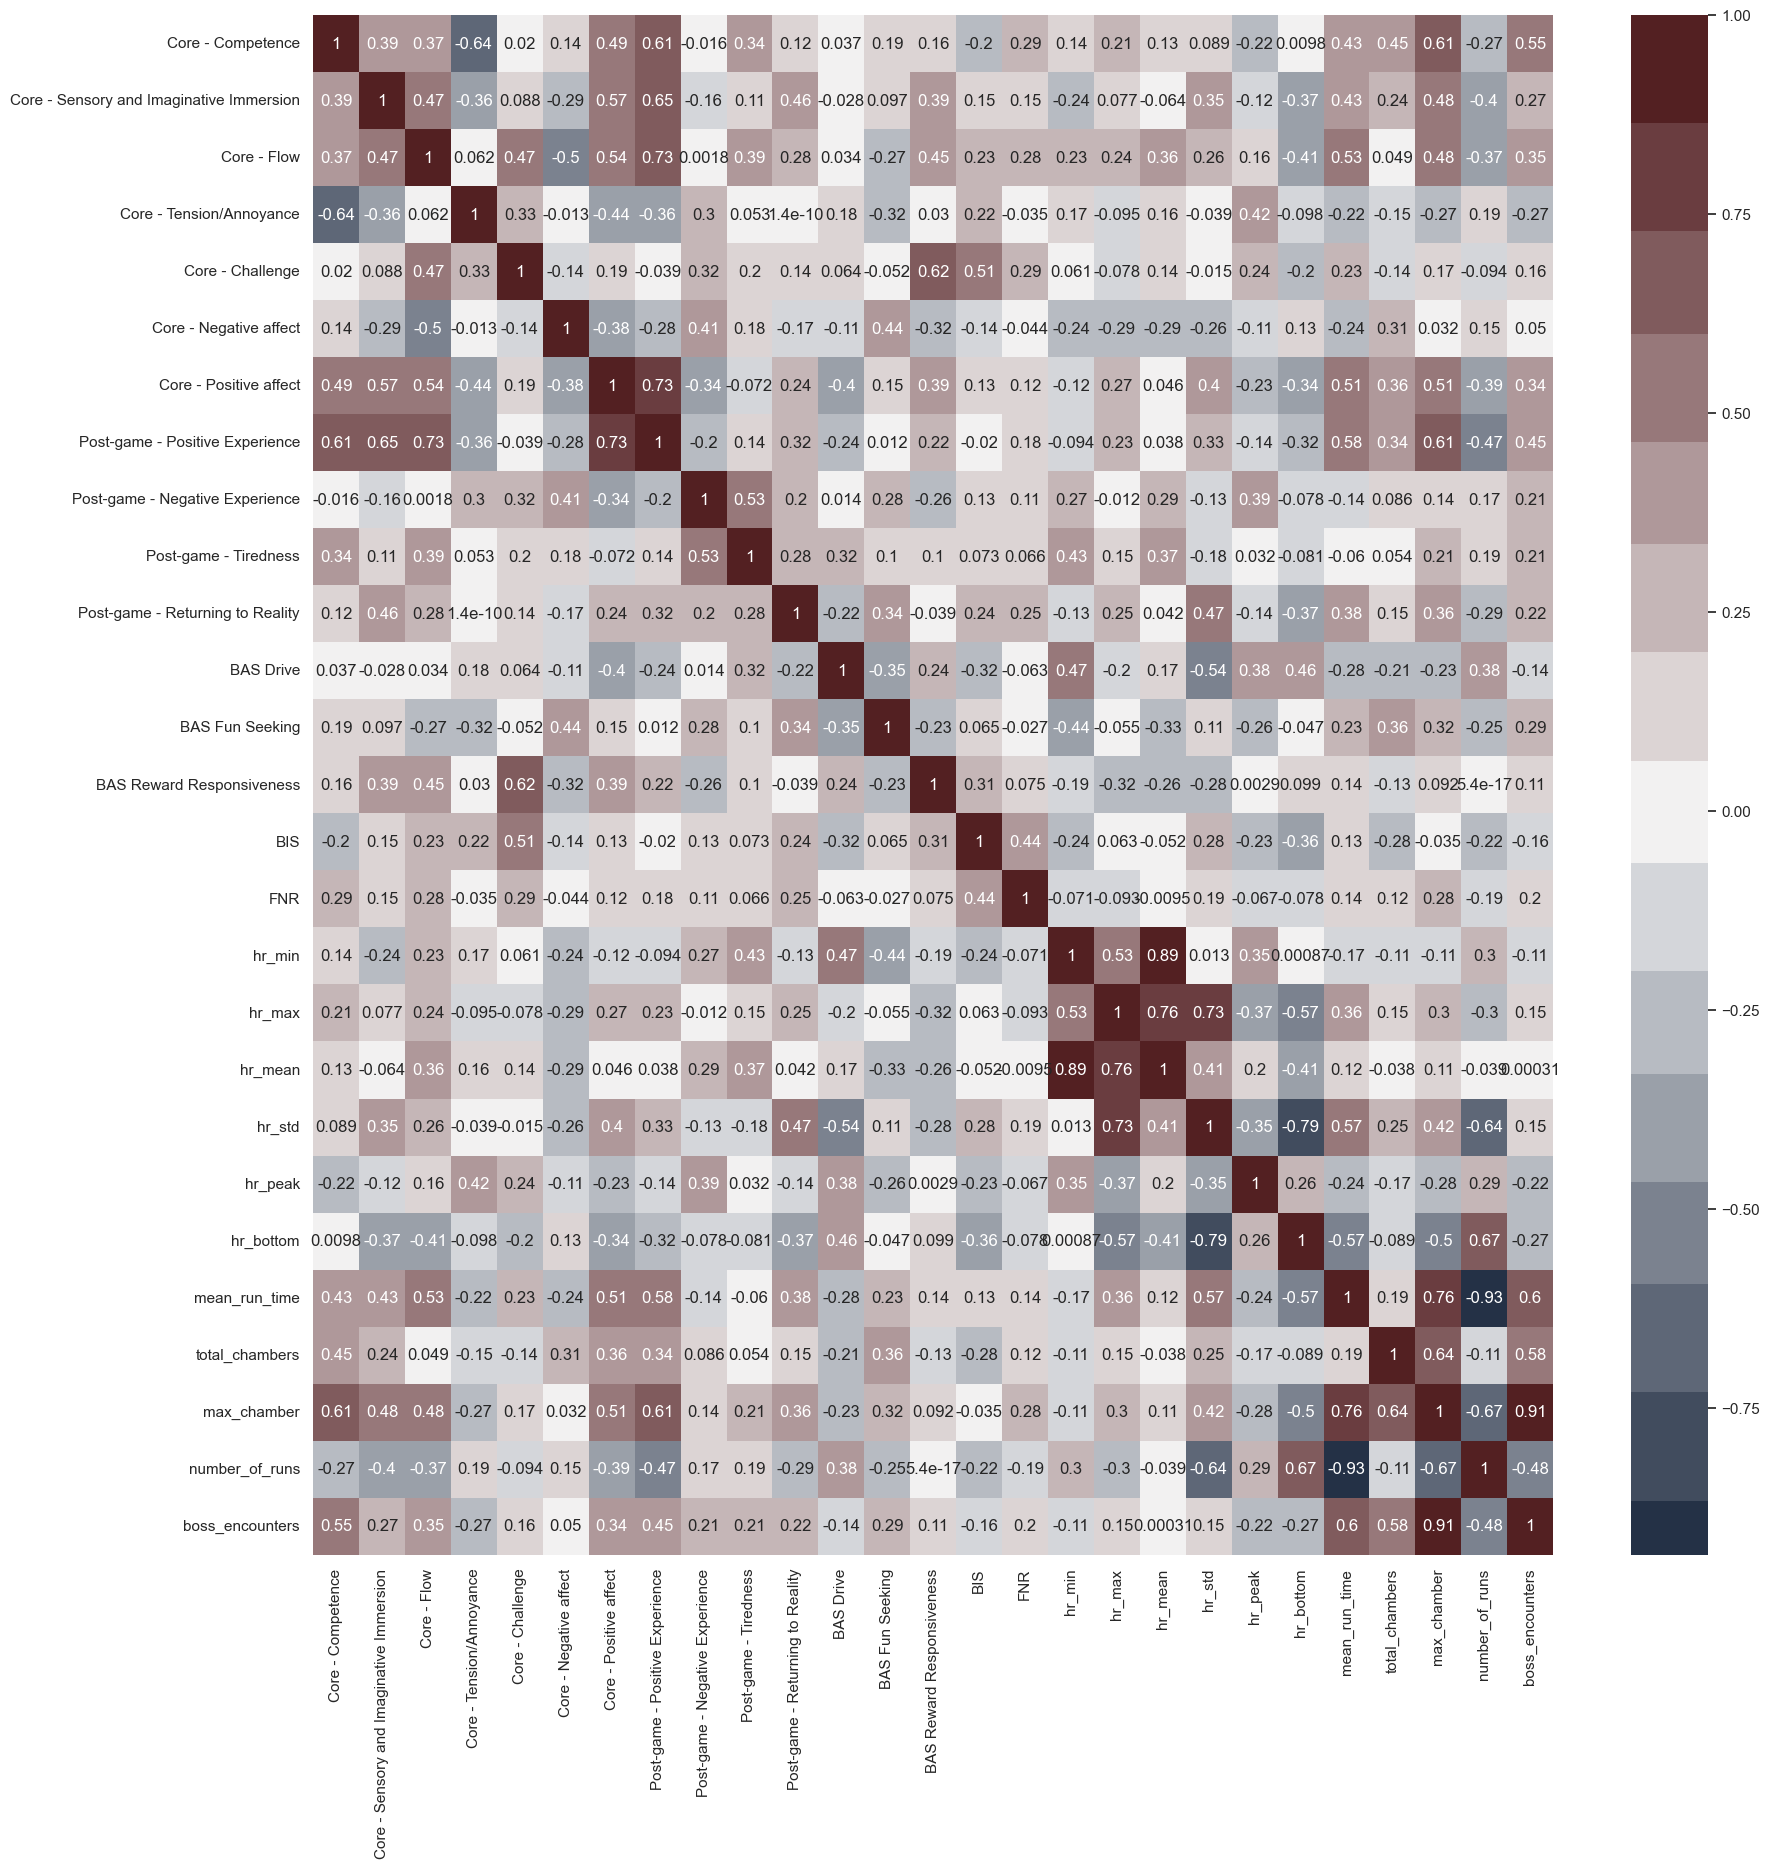

In [4]:
corr = full_set.corr(method="pearson")
sb.set(rc={'figure.figsize': (20, 20)})
sb.heatmap(corr, annot=True, center=0, cmap=sb.diverging_palette(250, 10, n=15, s=50, l=20))

## Hypothesis Testing: player performance (max_chamber)

In [5]:
false_discovery_rate = 0.05
median_performance = full_set["max_chamber"].median()
low_performers = full_set[:][full_set["max_chamber"] < median_performance]
high_performers = full_set[:][full_set["max_chamber"] >= median_performance]
performance_tests = pd.DataFrame([{"feature": c,
                                   "low performance mean": low_performers[c].mean(),
                                   "high performance mean": high_performers[c].mean(),
                                   "p-value": ttest_ind(low_performers[c], high_performers[c], equal_var=False)[1]}
                                  for c in full_set.columns]).set_index("feature")

performance_tests = performance_tests.sort_values(by=["p-value"]).reset_index()
performance_tests["BH"] = ((performance_tests.index + 1) / (len(performance_tests) - 1)) * false_discovery_rate
performance_tests["significant"] = performance_tests["p-value"] < performance_tests["BH"]

performance_tests

,feature,low performance mean,high performance mean,p-value,BH,significant
0,max_chamber,6.666667,12.727273,0.000005,0.001923,True
1,mean_run_time,329.093466,531.383182,0.000028,0.003846,True
2,number_of_runs,5.777778,3.818182,0.000327,0.005769,True
3,hr_std,4.627907,7.436733,0.000418,0.007692,True
4,hr_bottom,0.360511,0.165010,0.000524,0.009615,True
5,boss_encounters,0.000000,0.727273,0.003910,0.011538,True
6,Core - Positive affect,2.866667,3.490909,0.009365,0.013462,True
7,Post-game - Positive Experience,1.648148,2.439394,0.013173,0.015385,True
8,total_chambers,26.111111,31.727273,0.018260,0.017308,False
9,hr_max,101.555556,113.454545,0.023597,0.019231,False


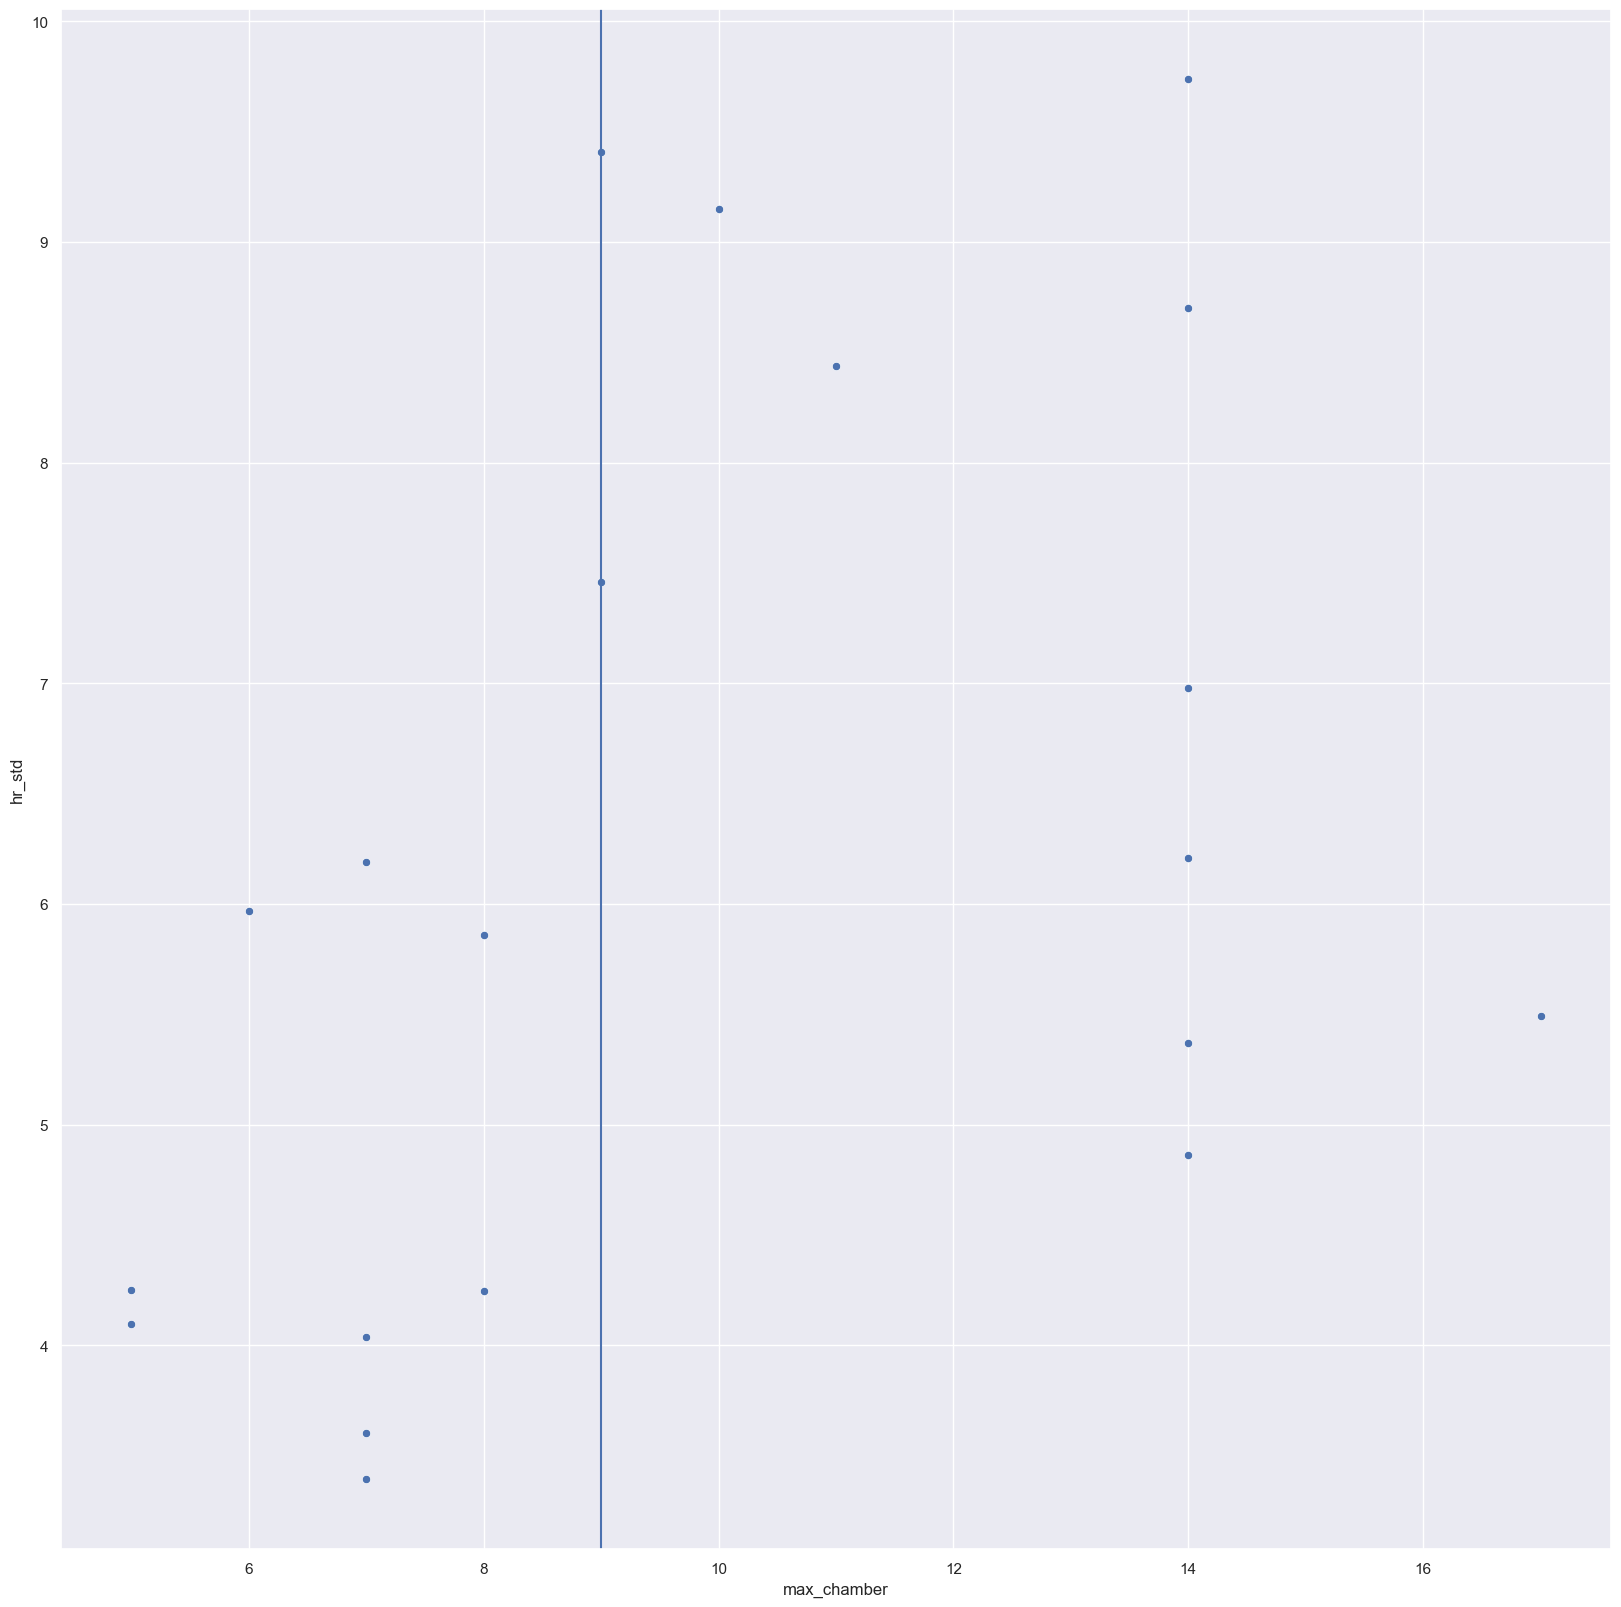

In [6]:
sb.scatterplot(data=full_set[["max_chamber", "hr_std"]], x="max_chamber", y="hr_std")
plt.axvline(x=median_performance)

## BIS/BAS as moderator

In [7]:
bisbas_mod = pd.DataFrame(
    {'moderator': [], 'moderator_coeff': [], 'independent': [], 'independent_coeff': [], 'dependent': [],
     'unmoderated r': [], 'moderated r': [], 'moderated p': []})
for c in full_set.columns:
    for d in full_set.columns:
        for e in full_set.columns:
            if ("BIS" in c or "BAS" in c or "FNR" in c) and (
                    "Post" not in d and "Core" not in d and "BIS" not in d and "BAS" not in d and "FNR" not in d) and (
                    "Post" in e or "Core" in e):
                clf = linear_model.LinearRegression()
                clf.fit(full_set[[c, d]], full_set[e])
                mediated_result = linregress(full_set[c] * clf.coef_[0] + full_set[d] * clf.coef_[1], full_set[e])
                result = linregress(full_set[d], full_set[e])
                if abs(mediated_result[2]) >= 0.65 and abs(mediated_result[2]) >= abs(result[2]) and mediated_result[
                    3] < 0.05:
                    bisbas_mod = pd.concat(
                        [bisbas_mod, pd.DataFrame([{'moderator': c, 'moderator_coeff': clf.coef_[0], 'independent': d,
                              'independent_coeff': clf.coef_[1], 'dependent': e,
                              'unmoderated r': result[2], 'moderated r': mediated_result[2],
                              'moderated p': mediated_result[3]}])],
                        ignore_index=True)

bisbas_mod

,moderator,moderator_coeff,independent,independent_coeff,dependent,unmoderated r,moderated r,moderated p
0,BAS Fun Seeking,-0.127792,mean_run_time,0.003259,Core - Flow,0.530129,0.665725,0.001356
1,BAS Fun Seeking,-0.144325,max_chamber,0.115783,Core - Flow,0.477202,0.651368,0.001864
2,BAS Reward Responsiveness,0.255316,hr_mean,0.039609,Core - Flow,0.361648,0.667884,0.001290
3,BAS Reward Responsiveness,0.242318,hr_mean,0.019434,Core - Challenge,0.137061,0.696283,0.000649
4,BAS Reward Responsiveness,0.194414,hr_std,0.150454,Core - Positive affect,0.400869,0.658293,0.001602
5,BAS Reward Responsiveness,0.212805,hr_peak,1.642833,Core - Challenge,0.242664,0.667251,0.001309
6,BAS Reward Responsiveness,0.222133,hr_bottom,-1.001846,Core - Challenge,-0.202288,0.676540,0.001055


## HR as moderator

In [8]:
hr_mod = pd.DataFrame(
    {'moderator': [], 'moderator_coeff': [], 'independent': [], 'independent_coeff': [], 'dependent': [],
     'unmoderated r': [], 'moderated r': [], 'moderated p': []})
for c in full_set.columns:
    for d in full_set.columns:
        for e in full_set.columns:
            if "hr_" in c and (
                    "hr" not in d and "Post" not in d and "Core" not in d and "BIS" not in d and "BAS" not in d and "FNR" not in d) and (
                    "Post" in e or "Core" in e):
                clf = linear_model.LinearRegression()
                clf.fit(full_set[[c, d]], full_set[e])
                mediated_result = linregress(full_set[c] * clf.coef_[0] + full_set[d] * clf.coef_[1], full_set[e])
                result = linregress(full_set[d], full_set[e])
                if abs(mediated_result[2]) >= 0.65 and abs(mediated_result[2]) >= abs(result[2]) and mediated_result[
                    3] < 0.05:
                    hr_mod = pd.concat(
                        [hr_mod, pd.DataFrame(
                            [{'moderator': c, 'moderator_coeff': clf.coef_[0], 'independent': d,
                              'independent_coeff': clf.coef_[1], 'dependent': e,
                              'unmoderated r': result[2], 'moderated r': mediated_result[2],
                              'moderated p': mediated_result[3]}])],
                        ignore_index=True)
hr_mod

,moderator,moderator_coeff,independent,independent_coeff,dependent,unmoderated r,moderated r,moderated p
0,hr_bottom,2.237662,max_chamber,0.169203,Core - Competence,0.614688,0.714199,0.000404


In [9]:
pd.concat([bisbas_mod,hr_mod]).to_latex()

'\\begin{tabular}{llrlrlrrr}\n\\toprule\n & moderator & moderator_coeff & independent & independent_coeff & dependent & unmoderated r & moderated r & moderated p \\\\\n\\midrule\n0 & BAS Fun Seeking & -0.127792 & mean_run_time & 0.003259 & Core - Flow & 0.530129 & 0.665725 & 0.001356 \\\\\n1 & BAS Fun Seeking & -0.144325 & max_chamber & 0.115783 & Core - Flow & 0.477202 & 0.651368 & 0.001864 \\\\\n2 & BAS Reward Responsiveness & 0.255316 & hr_mean & 0.039609 & Core - Flow & 0.361648 & 0.667884 & 0.001290 \\\\\n3 & BAS Reward Responsiveness & 0.242318 & hr_mean & 0.019434 & Core - Challenge & 0.137061 & 0.696283 & 0.000649 \\\\\n4 & BAS Reward Responsiveness & 0.194414 & hr_std & 0.150454 & Core - Positive affect & 0.400869 & 0.658293 & 0.001602 \\\\\n5 & BAS Reward Responsiveness & 0.212805 & hr_peak & 1.642833 & Core - Challenge & 0.242664 & 0.667251 & 0.001309 \\\\\n6 & BAS Reward Responsiveness & 0.222133 & hr_bottom & -1.001846 & Core - Challenge & -0.202288 & 0.676540 & 0.001055 \